In [4]:
from virusPropagationModel import *
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas
import time
import numpy
import math
import scipy.sparse


In [5]:
geopath = 'datafiles/'
geofiles = {1:'Buildings_Bad_Feilnbach_MA_1.csv',
            2:'Buildings_Bad_Feilnbach_MA_3.csv',
            3:'Buildings_Gangelt_MA_3.csv',
            4:'Buildings_Gangelt_MA_1.csv'}

In [45]:
modeledWorld1 = ModeledPopulatedWorld(1000,4, world_from_file=True, geofile_name=geopath+geofiles[4], agent_agent_infection=True, input_schedules='schedules_v2')
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('Distribution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 10316
Distribution of initialized locations: {'hospital': 1, 'morgue': 1, 'work': 74, 'public': 25, 'school': 2, 'home': 4908}


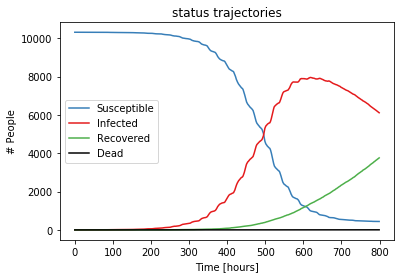

510.47133898735046


In [46]:
t0=time.time()

simulation1 = Simulation(modeledWorld1,800,run_immediately=False)

for p in simulation1.people:
    p.behaviour_as_infected=0.3
    
simulation1.interaction_frequency=2    
simulation1.simulate()
simulation1.plot_status_timecourse()
print(time.time()-t0)


In [47]:
t0=time.time()
trac2=simulation1.contact_tracing(tracing_window=240,time_span=[0, 600],loc_time_overlap_tracing=False,trace_all_following_infections=True)
print(time.time()-t0)

949.3145248889923


In [56]:
simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']>-1].shape

(9871, 8)

In [57]:
trac2['traced_all_downstream_infections'].sum()

8688

In [58]:
trac2['traced_preventable_downstream_infections'].sum()

7288

In [65]:
trac2.shape

(27, 7)

Text(0.5, 0, 'Days')

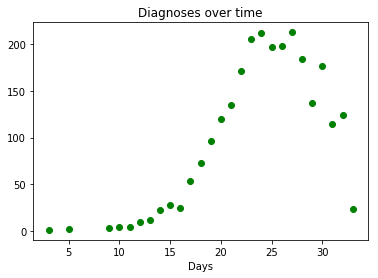

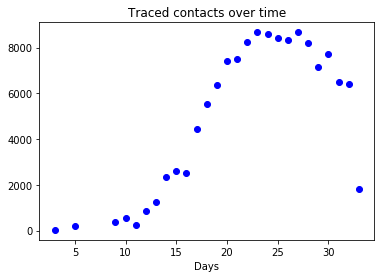

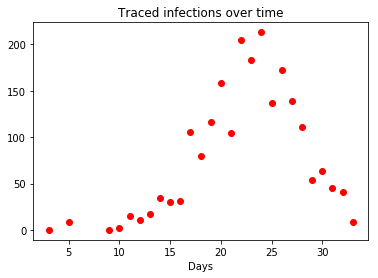

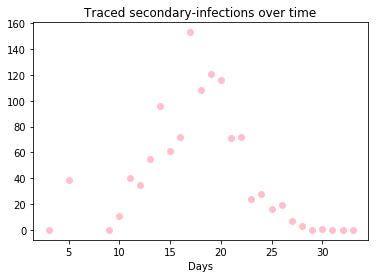

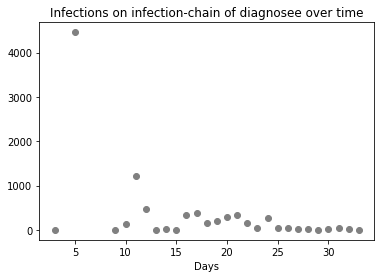

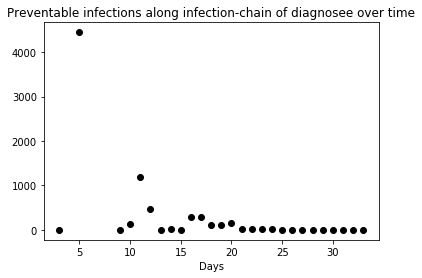

In [59]:
plt.figure()
plt.scatter(trac2.index,trac2['diagnosed_individuals'],color='green')
plt.title('Diagnoses over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_contacts'],color='blue')
plt.title('Traced contacts over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,trac2['traced_infections'],color='red')
plt.title('Traced infections over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,trac2['traced_secondary_infections'],color='pink')
plt.title('Traced secondary-infections over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_all_downstream_infections'],color='grey')
plt.title('Infections on infection-chain of diagnosee over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_preventable_downstream_infections'],color='black')
plt.title('Preventable infections along infection-chain of diagnosee over time')
plt.xlabel('Days')



Text(0.5, 0, 'Days')

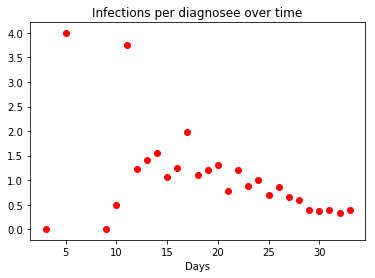

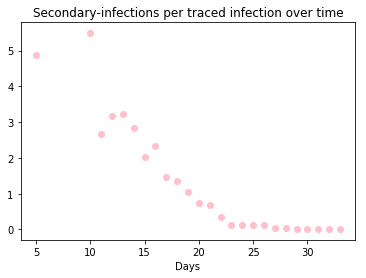

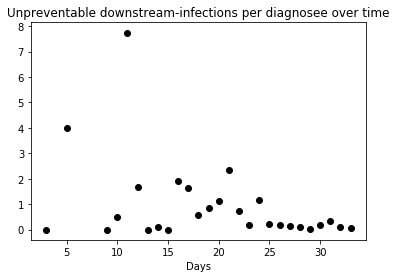

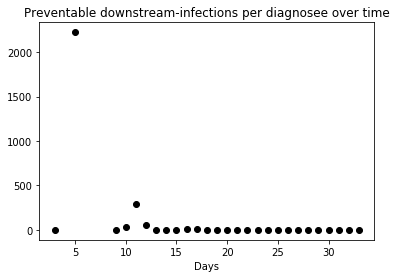

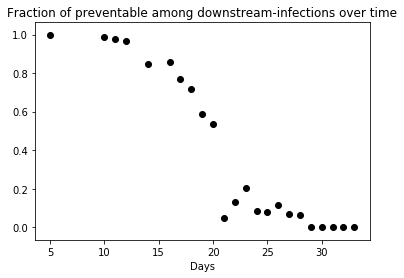

In [60]:
plt.figure()
plt.scatter(trac2.index,trac2['traced_infections']/trac2['diagnosed_individuals'],color='red')
plt.title('Infections per diagnosee over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,trac2['traced_secondary_infections']/trac2['traced_infections'],color='pink')
plt.title('Secondary-infections per traced infection over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,(trac2['traced_all_downstream_infections']-trac2['traced_preventable_downstream_infections'])/trac2['diagnosed_individuals'],color='black')
plt.title('Unpreventable downstream-infections per diagnosee over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_preventable_downstream_infections']/trac2['diagnosed_individuals'],color='black')
plt.title('Preventable downstream-infections per diagnosee over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_preventable_downstream_infections']/trac2['traced_all_downstream_infections'],color='black')
plt.title('Fraction of preventable among downstream-infections over time')
plt.xlabel('Days')





Text(0.5, 0, 'Days')

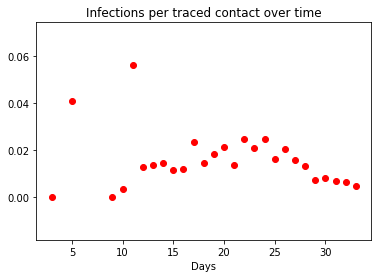

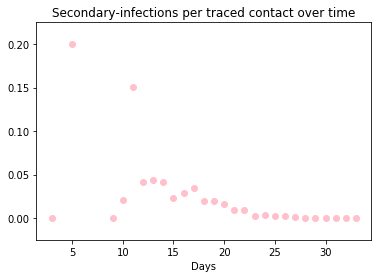

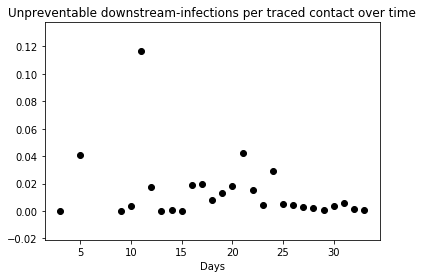

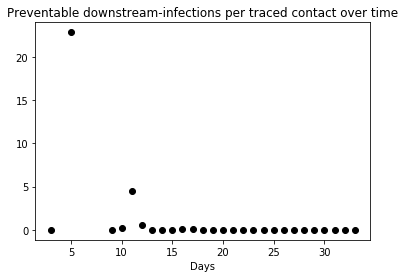

In [61]:
plt.figure()
plt.scatter(trac2.index,trac2['traced_infections']/trac2['traced_contacts'],color='red')
plt.title('Infections per traced contact over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,trac2['traced_secondary_infections']/trac2['traced_contacts'],color='pink')
plt.title('Secondary-infections per traced contact over time')
plt.xlabel('Days')


plt.figure()
plt.scatter(trac2.index,(trac2['traced_all_downstream_infections']-trac2['traced_preventable_downstream_infections'])/trac2['traced_contacts'],color='black')
plt.title('Unpreventable downstream-infections per traced contact over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_preventable_downstream_infections']/trac2['traced_contacts'],color='black')
plt.title('Preventable downstream-infections per traced contact over time')
plt.xlabel('Days')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Days')

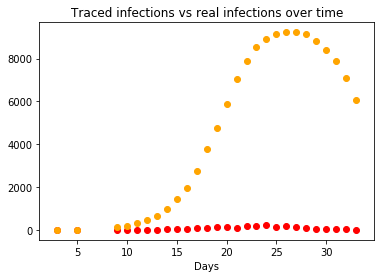

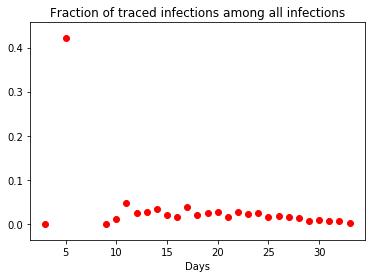

In [62]:
tc=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']>-1]
tc['day']=[int(i/24) for i in tc['time']]
days=[]
retro_infections=[]
for d in list(trac2.index):
    retro_infections.append(tc.loc[(tc['day']<=d)&(tc['day']>=d-14)].shape[0])
    days.append(d)


plt.figure()
plt.scatter(trac2.index,trac2['traced_infections'],color='red')
plt.scatter(days,retro_infections,color='orange')
plt.title('Traced infections vs real infections over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,trac2['traced_infections']/retro_infections,color='red')
plt.title('Fraction of traced infections among all infections')
plt.xlabel('Days')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Days')

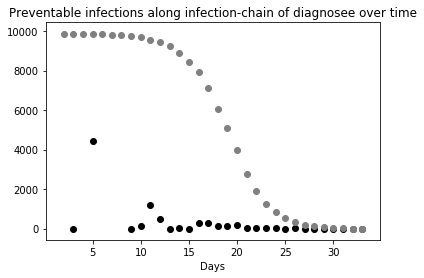

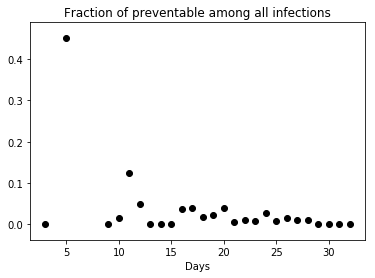

In [63]:
tc=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']>-1]
tc['day']=[int(i/24) for i in tc['time']]
days=[]
future_infections=[]
for d in list(tc['day'].unique()):
    future_infections.append(tc.loc[tc['day']>d].shape[0])
    days.append(d)
tot_infs=pandas.DataFrame(index=days)
tot_infs['infections']=future_infections


plt.figure()
plt.scatter(trac2.index,trac2['traced_preventable_downstream_infections'],color='black')
plt.scatter(days,future_infections,color='grey')
plt.title('Preventable infections along infection-chain of diagnosee over time')
plt.xlabel('Days')

maxtot=max([max(days),max(trac2.index)])
mintot=min([min(days),min(trac2.index)])

days_to_plot=list(range(mintot,maxtot+1))
prev_infs=trac2.loc[days_to_plot,'traced_preventable_downstream_infections']
infs=tot_infs.loc[days_to_plot,'infections']

plt.figure()
plt.scatter(days_to_plot,prev_infs/infs,color='black')
#plt.scatter(days_to_plot,infs,color='grey')
plt.title('Fraction of preventable among all infections')
plt.xlabel('Days')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ValueError: operands could not be broadcast together with shapes (20,) (23,) 

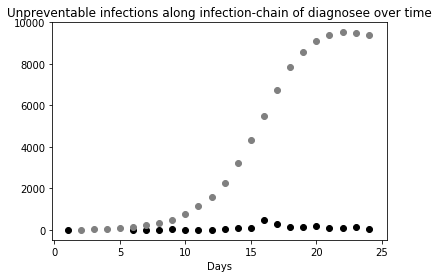

<Figure size 432x288 with 0 Axes>

In [43]:
tc=simulation1.simulation_timecourse.loc[simulation1.simulation_timecourse['Infection_event']>-1]
tc['day']=[int(i/24) for i in tc['time']]
days=[]
retro_infections=[]
for d in list(tc['day'].unique()):
    retro_infections.append(tc.loc[(tc['day']<=d)&(tc['day']>=d-14)].shape[0])
    days.append(d)

plt.figure()
plt.scatter(trac2.index,trac2['traced_all_downstream_infections']-trac2['traced_preventable_downstream_infections'],color='black')
plt.scatter(days,retro_infections,color='grey')
plt.title('Unpreventable infections along infection-chain of diagnosee over time')
plt.xlabel('Days')

plt.figure()
plt.scatter(trac2.index,(trac2['traced_all_downstream_infections']-trac2['traced_preventable_downstream_infections'])/retro_infections,color='black')
plt.scatter(days,retro_infections,color='grey')
plt.title('Unpreventable infections along infection-chain of diagnosee over time')
plt.xlabel('Days')




In [ ]:
plt.figure()
plt.scatter(trac3.index,trac3['traced_contacts'],color='blue')
plt.figure()
plt.scatter(trac3.index,trac3['traced_infections'],color='red')
plt.figure()
plt.scatter(trac3.index,trac3['diagnosed_individuals'],color='green')
plt.figure()
plt.scatter(trac3.index,trac3['loc_time_overlap'],color='orange')

In [ ]:
plt.figure()
plt.scatter(trac4.index,trac4['traced_contacts'],color='blue')
plt.figure()
plt.scatter(trac4.index,trac4['traced_infections'],color='red')
plt.figure()
plt.scatter(trac4.index,trac4['diagnosed_individuals'],color='green')
plt.figure()
plt.scatter(trac4.index,trac4['loc_time_overlap'],color='orange')

In [ ]:
plt.figure()
plt.scatter(trac1.index,trac1['traced_contacts']/trac1['diagnosed_individuals'],color='blue')
plt.figure()
plt.scatter(trac1.index,trac1['traced_infections']/trac1['diagnosed_individuals'],color='red')
plt.figure()
plt.scatter(trac1.index,trac1['loc_time_overlap']/trac1['diagnosed_individuals'],color='orange')


In [ ]:
trac1=simulation1.contact_tracing(tracing_window=336)
plt.figure()
plt.scatter(trac1.index,trac['traced_contacts'],color='blue')
plt.figure()
plt.scatter(trac1.index,trac['traced_infections'],color='red')

In [ ]:
trac1=simulation1.contact_tracing(tracing_window=500)
plt.figure()
plt.scatter(trac1.index,trac['traced_contacts'],color='blue')
plt.figure()
plt.scatter(trac1.index,trac['traced_infections'],color='red')

In [ ]:
simulation1.simulation_timecourse

In [ ]:
x=list(zip([1,2,3],[4,5,6]))
x

In [ ]:
a,b=zip(*x)

In [ ]:
a

In [ ]:
b

In [ ]:
type(simulation1.simulation_timecourse.loc[50819,'h_ID'])

In [ ]:
simulation1.plot_infections_per_location_type(relative_to_building_number=False,save_figure=True)

In [ ]:
simulation1.plot_interaction_patterns()

In [ ]:
simulation1.plot_infection_patterns()

In [ ]:
simulation1.get_age_group_specific_interaction_patterns()

In [ ]:
simulation1.get_infections_per_location_type()

In [ ]:
hh_tot=simulation1.get_number_of_infected_households(time_span=[0, None], total=True)

In [ ]:
hh_time_DF=simulation1.get_number_of_infected_households(time_span=[0, 400])

plt.plot(hh_time_DF['time'],hh_time_DF['households'])

In [ ]:
trac=simulation1.contact_tracing()

In [ ]:
trac

In [ ]:
trac.loc[trac['aggregated_time']>=6].shape

In [ ]:
plt.scatter(trac['aggregated_time'],trac['traced_contacts'],color='blue')
#plt.scatter(trac['aggregated_time'],trac['traced_infections'],color='red')

In [ ]:
plt.scatter(trac['aggregated_time'],trac['traced_infections'],color='red')

In [ ]:
infe=simulation1.get_status_trajectories()['I']

In [ ]:
infe

In [ ]:

plt.plot(hh_time_DF['time'],hh_time_DF['households'])
plt.plot(infe.loc[infe['time']<=400,'time'],infe.loc[infe['time']<=400,'I'],color='red')

In [ ]:
tracing=simulation1.contact_tracing()
tracing['traced_contacts'].unique()


In [ ]:
tracing

In [ ]:
x=tracing.groupby(['aggregated_time']).sum()

In [ ]:
x

In [ ]:
plt.scatter(x.index,x['traced_contacts'])
plt.scatter(x.index,x['traced_infections'],color='red')

In [ ]:
#simulation1.get_age_group_specific_infection_patterns(n_time_aggregates=10)
plt.pcolor(simulation1.get_age_group_specific_infection_patterns(n_time_aggregates=10))

In [ ]:
plt.pcolor(simulation1.get_age_group_specific_interaction_patterns(n_time_aggregates=10))

In [ ]:
Agents={str(p.ID):p.age for p in list(modeledWorld1.people)}
Agent_Ages=pandas.DataFrame()
Agent_Ages['ID']=[int(i) for i in list(Agents.keys())]
Agent_Ages['Age']=list(Agents.values())

age_groups=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
Agent_Ages['AgeGroup']=[-1]*Agent_Ages.shape[0]
for i in age_groups:
    age_index=age_groups.index(i)
    if age_groups.index(i)<len(age_groups)-1:
        lower_bound=i
        upper_bound=age_groups[age_index+1]
        agent_ids=Agent_Ages.loc[(Agent_Ages['Age']>=lower_bound)&(Agent_Ages['Age']<upper_bound),'ID']
        Agent_Ages.loc[Agent_Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)
    else:    
        lower_bound=i
        agent_ids=Agent_Ages.loc[Agent_Ages['Age']>=lower_bound,'ID']
        Agent_Ages.loc[Agent_Ages['ID'].isin(agent_ids),'AgeGroup']=int(i)

In [ ]:
simulation1 = Simulation(modeledWorld1,1200,run_immediately=False)
simulation2 = Simulation(modeledWorld1,200,run_immediately=False)


simulation1.interaction_matrix = True
simulation2.interaction_matrix = True
simulation1.interaction_frequency = 4
simulation2.interaction_frequency = 4

simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.15,'type':'replacement'}}})
simulation2.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.15,'type':'replacement'}}})
simulation1.simulate()
simulation1.plot_status_timecourse()


simulation2.simulate()
simulation3 = Simulation(simulation2,1000,run_immediately=False)
for p in list(simulation3.people):
    p.stay_home_instead_of_going_to('work')
    p.stay_home_instead_of_going_to('school')
    p.stay_home_instead_of_going_to('public')
simulation3.simulate()

simulation3.plot_status_timecourse()





In [ ]:
def build_infection_matrix(simulation,lowest_timestep=0,highest_timestep=None):
    if highest_timestep is None:
        max_ts=simulation.simulation_timecourse['time'].max()
    else:
        max_ts=highest_timestep
    Timecourse=simulation.simulation_timecourse[(simulation.simulation_timecourse['time']>=lowest_timestep)&(simulation.simulation_timecourse['time']<=max_ts)]
    
    Infections=Timecourse.loc[Timecourse['Infection_event']>=0,:]
    Days=[int(i/24) for i in Infections['time']]
    Infections['day']=Days
    individuals=list(Timecourse['h_ID'].unique())
    #out={}
    infection_matrix=numpy.zeros((len(individuals),len(individuals)))
    for d in list(Infections['day'].unique()):
        DayFrame=Infections.loc[Infections['day']==d,]
        did_infect_array=numpy.zeros((len(individuals),len(individuals)))
        for i in list(DayFrame.index):
            did_infect_array[individuals.index(DayFrame.loc[i,'h_ID']),individuals.index(DayFrame.loc[i,'Infection_event'])]=1
        infection_matrix+=did_infect_array
    #### cols=spreaders rows=receivers    
    return(pandas.DataFrame(infection_matrix,index=individuals,columns=individuals))

def build_agegroup_aggregated_infection_matrix(Infection_matrix,Ages,days=5):
    Infection_matrix['AgeGroup_object']=[-1]*Infection_matrix.shape[0]

    for i in list(Infection_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Infection_matrix.loc[i,'AgeGroup_object']=agePerson
    CMgroup=Infection_matrix.groupby(['AgeGroup_object']).sum()
    CMgroup.loc['AgeGroup_subject',:]=[-1]*CMgroup.shape[1]

    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_subject',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_subject']).sum()
    perday=Out/days
    return(perday)



In [ ]:
def build_interaction_matrix(simulation,lowest_timestep=0,highest_timestep=None):
    if highest_timestep is None:
        max_ts=simulation.simulation_timecourse['time'].max()
    else:
        max_ts=highest_timestep
    Timecourse=simulation.simulation_timecourse[(simulation.simulation_timecourse['time']>=lowest_timestep)&(simulation.simulation_timecourse['time']<=max_ts)]
    
    #Infections=Timecourse.loc[Timecourse['Infection_event']>=0,:]
    Interactions=Timecourse.loc[Timecourse['Interaction_partner']!='',:]
    Days=[int(i/24) for i in Interactions['time']]
    Interactions['day']=Days
    individuals=[int(i) for i in list(Timecourse['h_ID'].unique())]
    individual_dict=dict(zip(individuals,list(range(len(individuals)))))
    #out={}
    interaction_matrix=scipy.sparse.csr_matrix(numpy.zeros((len(individuals),len(individuals))))
    for d in list(Interactions['day'].unique()):
        DayFrame=Interactions.loc[Interactions['day']==d,]
        #person_indices,contact_indices=zip(*[(individual_dict[int(DayFrame.loc[i,'h_ID'])],individual_dict[int(k)]) for j in [DayFrame.loc[i,'Interaction_partner'].split(',') for i in DayFrame.index] for k in j])
        contact_indices=[individual_dict[int(j)] for i in list(DayFrame['Interaction_partner']) for j in i.split(',')]
        #contact_indices=[individuals.index(int(j)) for i in list(DayFrame.index) for j in DayFrame.loc[i,'Interaction_partner'].split(',')]
        person_indices=[individual_dict[int(i)] for i in list(DayFrame['h_ID'])]
        person_indices=[]
        for i in DayFrame.index:
            appendix_list=[individual_dict[int(DayFrame.loc[i,'h_ID'])]]*len(DayFrame.loc[i,'Interaction_partner'].split(','))
            person_indices+=appendix_list
        #person_indices=[for j in [[individual_dict[int(DayFrame.loc[i,'h_ID'])]]*len(DayFrame.loc[i,'Interaction_partner'].split(',')) for i in DayFrame.index] for k in j]
        #person_indices=[individuals.index(DayFrame.loc[i,'h_ID']) for i in list(DayFrame.index)]
        interaction_matrix[contact_indices,person_indices]+=1
        
    #### cols=subject rows=object    
    return(pandas.DataFrame(interaction_matrix.toarray(),index=individuals,columns=individuals))

def build_agegroup_aggregated_interaction_matrix(Interaction_matrix,Ages,days=5):
    Interaction_matrix['AgeGroup_subject']=[-1]*Interaction_matrix.shape[0]

    for i in list(Interaction_matrix.index):
        agePerson=Ages.loc[Ages['ID']==i,'AgeGroup'].values[0]
        Interaction_matrix.loc[i,'AgeGroup_subject']=agePerson
    CMgroup=Interaction_matrix.groupby(['AgeGroup_subject']).mean()

    CMgroup.loc['AgeGroup_object',:]=[-1]*CMgroup.shape[1]
    for i in list(CMgroup.columns):
        agePerson=Ages.loc[Ages['ID']==int(i),'AgeGroup'].values[0]
        CMgroup.loc['AgeGroup_object',i]=agePerson
    Out=CMgroup.transpose().groupby(['AgeGroup_object']).sum()
    perday=Out/days
    return(perday)






In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

#chosenColorMap=plt.cm.Blues
chosenColorMap=plt.cm.Reds


Infection_HeatmapDF_baseline=build_agegroup_aggregated_infection_matrix(build_infection_matrix(simulation1),Agent_Ages,50)
Infection_HeatmapDF_lockdown=build_agegroup_aggregated_infection_matrix(build_infection_matrix(simulation3),Agent_Ages,50)

DiffDF=Infection_HeatmapDF_baseline-Infection_HeatmapDF_lockdown



max_tot=max([Infection_HeatmapDF_baseline.max().max(),Infection_HeatmapDF_lockdown.max().max()])
min_tot=min([Infection_HeatmapDF_baseline.min().min(),Infection_HeatmapDF_lockdown.min().min()])

y_tick_positions=np.arange(0.5, len(Infection_HeatmapDF_lockdown.index), 1)[::2]
x_tick_positions=np.arange(0.5, len(Infection_HeatmapDF_lockdown.index), 1)[::2]
x_tick_labels=[int(i) for i in Infection_HeatmapDF_lockdown.columns][::2]
y_tick_labels=[int(i) for i in Infection_HeatmapDF_lockdown.index][::2]



plt.figure(figsize=(18/1.25, 5/1.25))

plt.subplot(1, 3, 1)
heatmap=plt.pcolor(Infection_HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection donor (age-groups)')
plt.ylabel('Infection acceptor (age-groups)')

plt.subplot(1, 3, 2)
heatmap=plt.pcolor(Infection_HeatmapDF_lockdown, cmap=chosenColorMap, vmin = Infection_HeatmapDF_lockdown.min().min(), vmax = Infection_HeatmapDF_lockdown.max().max())
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Lockdown infections per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection donor (age-groups)')
plt.ylabel('Infection acceptor (age-groups)')

plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Infection difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Infection donor (age-groups)')
plt.ylabel('Infection acceptor (age-groups)')

plt.tight_layout()

plt.savefig('AgeGroup_InfectionHeatmap_Mu_4_Inf_01k5.png')
#plt.savefig('AgeGroup_InfectionHeatmap_oldInfectionMechanism.png')

#plt.show()

In [ ]:
#plt.figure(figsize=(10, 5))

#plt.subplot(1, 2, 1)

chosenColorMap=plt.cm.Blues


Interaction_HeatmapDF_baseline=build_agegroup_aggregated_interaction_matrix(build_interaction_matrix2(simulation1),Agent_Ages,7)
Interaction_HeatmapDF_lockdown=build_agegroup_aggregated_interaction_matrix(build_interaction_matrix2(simulation2),Agent_Ages,7)

DiffDF=Interaction_HeatmapDF_baseline-Interaction_HeatmapDF_lockdown



max_tot=max([Interaction_HeatmapDF_baseline.max().max(),Interaction_HeatmapDF_lockdown.max().max()])
min_tot=min([Interaction_HeatmapDF_baseline.min().min(),Interaction_HeatmapDF_lockdown.min().min()])

y_tick_positions=np.arange(0.5, len(Interaction_HeatmapDF_lockdown.index), 1)[::2]
x_tick_positions=np.arange(0.5, len(Interaction_HeatmapDF_lockdown.index), 1)[::2]
x_tick_labels=[int(i) for i in Interaction_HeatmapDF_lockdown.columns][::2]
y_tick_labels=[int(i) for i in Interaction_HeatmapDF_lockdown.index][::2]



plt.figure(figsize=(18/1.25, 5/1.25))

plt.subplot(1, 3, 1)
heatmap=plt.pcolor(Interaction_HeatmapDF_baseline, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Interactions per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Interaction subject (age-groups)')
plt.ylabel('Interaction object (age-groups)')

plt.subplot(1, 3, 2)
heatmap=plt.pcolor(Interaction_HeatmapDF_lockdown, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Lockdown Interactions per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Interaction subject (age-groups)')
plt.ylabel('Interaction object (age-groups)')

plt.subplot(1, 3, 3)
heatmap=plt.pcolor(DiffDF, cmap=chosenColorMap, vmin = min_tot, vmax = max_tot)
plt.yticks(y_tick_positions, y_tick_labels)
plt.xticks(x_tick_positions, x_tick_labels)
plt.colorbar(heatmap)
plt.title('Interaction difference per age-group')
#plt.ylim((-0.1,4))
plt.xlabel('Interaction subject (age-groups)')
plt.ylabel('Interaction object (age-groups)')

plt.tight_layout()

plt.savefig('AgeGroup_InteractionHeatmap_Mu_05.png')
#plt.show()